# Objective
We have the objective to describe every hotel on Booking.com in 5 positve words and 5 negative words.

Generally, for every review given, we want to extract the most important positive and negative descriptor words. Then we then rank these words based on frequency of appearance per hotel based on that hotel's reviews. In this way we can get a description of each hotel in 10 words. <br>

The approach will be:
* create a corpus per review that is a combination of positive and negative aspects of the review
* create a tf-idf score for the top n words of each review
* find the top 5 positive and top 5 negative words per hotel
* make 2 additional models trained on only the positive and negative reviews respectively. The subsequent steps are the same as for 1 model


In [66]:
import pandas as pd
import pandas
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.feature_extraction.text import TfidfTransformer


dataset = pd.read_csv('./Hotel_Reviews.csv')

hotel_id = None
if hotel_id is not None:
    print(dataset['Hotel_Name'].unique()[hotel_id])
    dataset = dataset[dataset['Hotel_Name'] == dataset['Hotel_Name'].unique()[hotel_id]]
    print('number of reviews for this hotel = ' + str(len(dataset)))
else:
    print('training on all hotels!')    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rudy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rudy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


training on all hotels!


# Definition of extra stop words based on experience

In [67]:
stop_words = set(stopwords.words("english"))
new_words = ['go', 'nothing']
stop_words = stop_words.union(new_words, stop_words)

# Clean the dataset 
to clean we:
* create a corpus containing a combination of positive and negative reviews
* get rid of all instances of absent positive or negative reviews, and replace the 'No Review' blank with ''

In [68]:
dataset["review"] = dataset['Positive_Review'] + dataset['Negative_Review']
dataset["review"] = dataset["review"].apply(lambda x: str(x).replace("No Negative", "").replace("No Positive", ""))

dataset['Positive_Review'] = dataset['Positive_Review'].apply(lambda x: str(x).replace("No Negative", '').replace("No Positive", ''))
dataset['Negative_Review'] = dataset['Negative_Review'].apply(lambda x: str(x).replace("No Negative", '').replace("No Positive", ''))


# Noise removal and normalization

We remove noise from the review corpus and we normalize in order to remove sparsity in the word matrix. 

Normalization removes multiple occurrances or representations of a word. The stemming technique normalizes by removing suffixes, and the lemmatization echnique examines the roots of words for this reduction.

We also want to remove stopwords, which are filler words that occur very often and contain no value.

In [69]:
def clean_corpus(var):
    text = re.sub('[^a-zA-Z]', ' ', var)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    #s=PorterStemmer()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words]
    
    text = " ".join(text)
    return text

In [70]:
dataset['Positive_Review_norm'] = dataset['Positive_Review'].apply(clean_corpus)
dataset['Negative_Review_norm'] = dataset['Negative_Review'].apply(clean_corpus)

In [71]:
# examine the difference between original and normalized 
id = 2
print(dataset['Positive_Review'].iloc[id])
print('\n')
print(dataset['Positive_Review_norm'].iloc[id])
print('\n')
print(dataset['Negative_Review'].iloc[id])
print('\n')
print(dataset['Negative_Review_norm'].iloc[id])

 Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back 


location good staff ok cute hotel breakfast range nice back


 Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge 


room nice elderly bit difficult room two story narrow step ask single level inside room basic tea coffee boiler bar empty fridge


In [72]:
# a series of strings, each string containing a review. Collectively they are a corpus
corpus_pos = dataset['Positive_Review_norm']
corpus_neg = dataset['Negative_Review_norm']

We now have a corpus of words that has been normalized and has had noise removed. There is a positive and a negative corpus per review.

# Text Preparation - Tokenization and vectorization
Now the corpus has to be converted into a normalized format that the algorithms can interpret without tricky aspect of language causing problems.

Now we need to create a vector of word counts (a bag of words). This turns a series of strings into a vector of (unique?) words. <br>

description of variables used to define vectorizer:

max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

max_features — determines the number of columns in the matrix.

n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

In [73]:
# count vectorizer object
cv_pos = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 10000, ngram_range = (1,3))
cv_neg = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 10000, ngram_range = (1,3))
cv_pos

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words={'its', 'just', 'how', 'being', 'off', 'haven', "it's", 'we', 'further', 'the', "hadn't", 'about', "you've", 'down', 'didn', 'her', 'all', 'some', 'any', 'too', 'be', 'my', 'y', 'nothing', 'themselves', 'but', 'having', 'by', 'doing', 'them', 'or', 'above', 'which', 'during', 'such', 'had...', 'same', 'are', 'hers', 'him', "isn't", 'at', 'yours', 'for', "hasn't", 'an', 'here', 'own', 'to'},
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
# returns a sparse matrix representation of the counts
# to fit a count vectorizor object to a corpus returns a matrix of n_documents, n_words in vector
# cv = count vectorizer object
# X_pos = sparse vocabulary matrix

X_pos = cv_pos.fit_transform(corpus_pos)
X_neg = cv_neg.fit_transform(corpus_neg)

A sparse vocabulary matrix, or a word count vector, is returned

In [75]:
list(cv_pos.vocabulary_.keys())[:20]

['park',
 'outside',
 'hotel',
 'beautiful',
 'outside hotel',
 'hotel beautiful',
 'real',
 'complaint',
 'great',
 'location',
 'surroundings',
 'room',
 'amenity',
 'service',
 'two',
 'recommendation',
 'however',
 'staff',
 'upon',
 'check']

In [76]:
# N-documents x n_words, with counts, as a sparse matrix
X_pos
len(cv_pos.vocabulary_.keys())

10000

# Examine top uni and bigrams of encoded vectors

In [77]:
# Most frequently occuring words
def get_top_n_words(corpus, n=None):
    # fit the count vectorizer to the corpus so it can be used to do things
    cv = CountVectorizer().fit(corpus)
    # encoded vector
    bag_of_words = cv.transform(corpus)
    # number of words
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]


[Text(0, 0, 'staff'),
 Text(0, 0, 'location'),
 Text(0, 0, 'room'),
 Text(0, 0, 'hotel'),
 Text(0, 0, 'good'),
 Text(0, 0, 'great'),
 Text(0, 0, 'breakfast'),
 Text(0, 0, 'friendly'),
 Text(0, 0, 'helpful'),
 Text(0, 0, 'nice'),
 Text(0, 0, 'clean'),
 Text(0, 0, 'bed'),
 Text(0, 0, 'excellent'),
 Text(0, 0, 'comfortable'),
 Text(0, 0, 'lovely'),
 Text(0, 0, 'stay'),
 Text(0, 0, 'station'),
 Text(0, 0, 'close'),
 Text(0, 0, 'really'),
 Text(0, 0, 'service')]

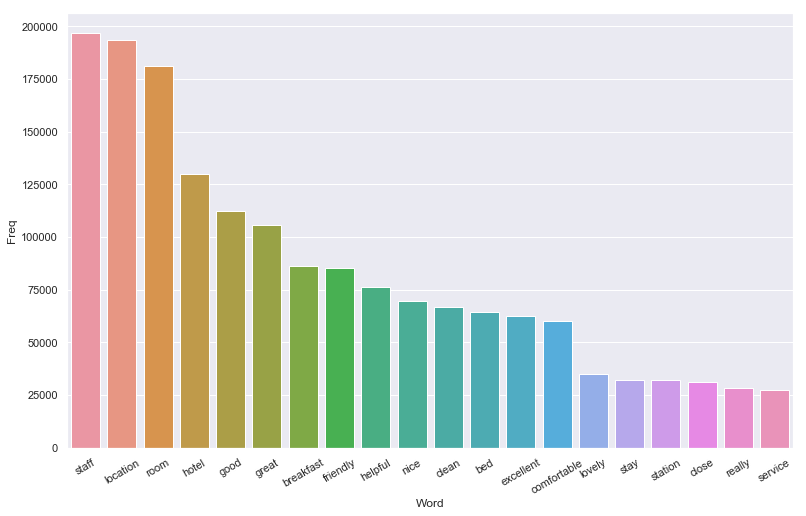

In [78]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus_pos, n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [79]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


                   Tri-gram  Freq
0    staff friendly helpful  9641
1    friendly helpful staff  6906
2   location friendly staff  3669
3    staff helpful friendly  3118
4          good value money  2542
5   within walking distance  2418
6      hotel great location  2324
7      staff great location  2106
8     would definitely stay  2050
9   staff extremely helpful  1962
10      friendly staff good  1778
11   room clean comfortable  1748
12   helpful friendly staff  1712
13  great location friendly  1619
14     room comfortable bed  1598
15     friendly staff great  1478
16      staff good location  1414
17    friendly helpful room  1323
18     location great staff  1293
19        great value money  1290


[Text(0, 0, 'staff friendly helpful'),
 Text(0, 0, 'friendly helpful staff'),
 Text(0, 0, 'location friendly staff'),
 Text(0, 0, 'staff helpful friendly'),
 Text(0, 0, 'good value money'),
 Text(0, 0, 'within walking distance'),
 Text(0, 0, 'hotel great location'),
 Text(0, 0, 'staff great location'),
 Text(0, 0, 'would definitely stay'),
 Text(0, 0, 'staff extremely helpful'),
 Text(0, 0, 'friendly staff good'),
 Text(0, 0, 'room clean comfortable'),
 Text(0, 0, 'helpful friendly staff'),
 Text(0, 0, 'great location friendly'),
 Text(0, 0, 'room comfortable bed'),
 Text(0, 0, 'friendly staff great'),
 Text(0, 0, 'staff good location'),
 Text(0, 0, 'friendly helpful room'),
 Text(0, 0, 'location great staff'),
 Text(0, 0, 'great value money')]

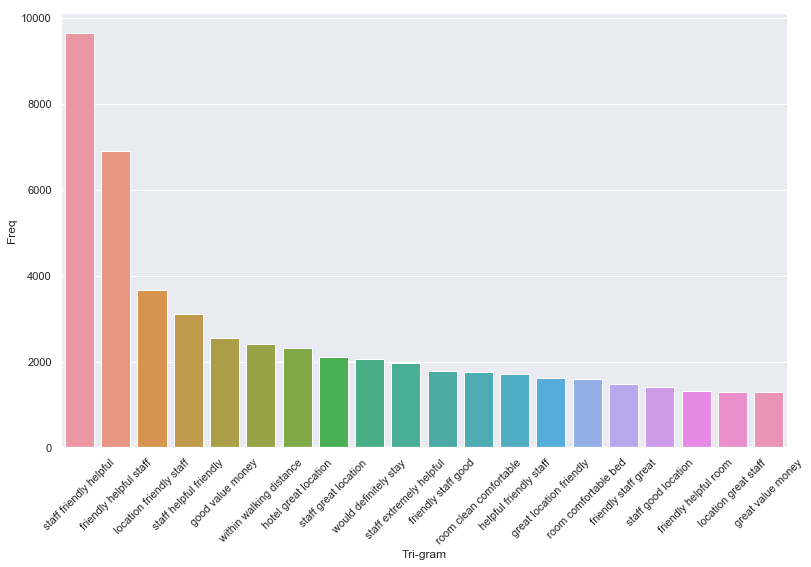

In [80]:
top3_words = get_top_n3_words(corpus_pos, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                    Tri-gram  Freq
0             room bit small  1584
1          room little small  1236
2           room quite small  1056
3     coffee making facility   988
4       making facility room   916
5          tea coffee making   892
6        tea coffee facility   728
7             two single bed   714
8   breakfast included price   595
9            four star hotel   557
10           tea coffee room   542
11    breakfast could better   535
12       bed pushed together   516
13       tea making facility   501
14          front desk staff   499
15      coffee facility room   493
16      room extremely small   487
17     air conditioning room   487
18           far city center   475
19             room th floor   472


[Text(0, 0, 'room bit small'),
 Text(0, 0, 'room little small'),
 Text(0, 0, 'room quite small'),
 Text(0, 0, 'coffee making facility'),
 Text(0, 0, 'making facility room'),
 Text(0, 0, 'tea coffee making'),
 Text(0, 0, 'tea coffee facility'),
 Text(0, 0, 'two single bed'),
 Text(0, 0, 'breakfast included price'),
 Text(0, 0, 'four star hotel'),
 Text(0, 0, 'tea coffee room'),
 Text(0, 0, 'breakfast could better'),
 Text(0, 0, 'bed pushed together'),
 Text(0, 0, 'tea making facility'),
 Text(0, 0, 'front desk staff'),
 Text(0, 0, 'coffee facility room'),
 Text(0, 0, 'room extremely small'),
 Text(0, 0, 'air conditioning room'),
 Text(0, 0, 'far city center'),
 Text(0, 0, 'room th floor')]

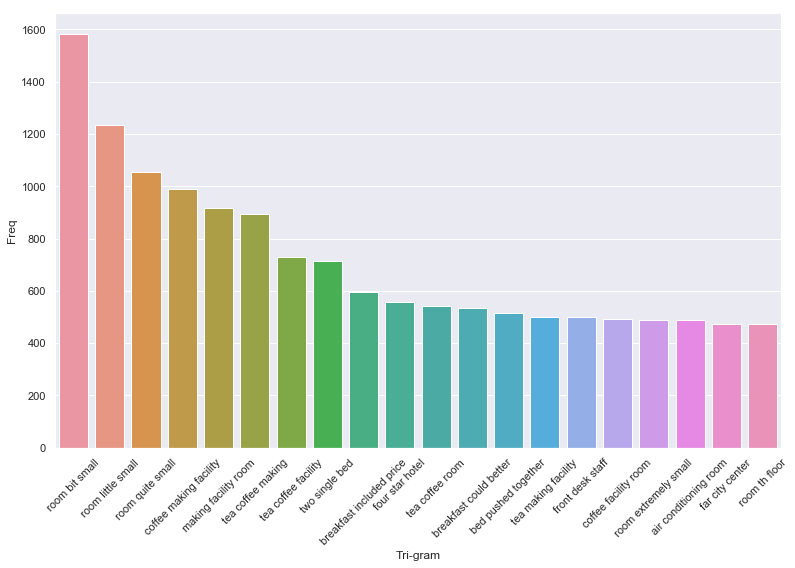

In [81]:
top3_words = get_top_n3_words(corpus_neg, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

# Computing TD-IDF

Our vectorized corpus contains a large number of words, now we need to quantify their impact and frequency. Not all words are important, so we need to filter out the unimportant ones using an algorithm more sophisticated than 'frequency'. For this we use TD-IDF.

TF = Frequency of a term in a document / total number of terms in the document

IDF = log(total documents) / # of documents with the term

We are fitting the IDF (tfidf) object based on some sample documents we expect to be representative of the test set.


In [82]:
#TfidfTransformer object
tfidf_transformer_pos = TfidfTransformer(smooth_idf=True, use_idf = True)
# fit an IDF to a sparse matrix  
# X_pos was the return of the countvectorizor object fit on a corpus ( a sparse matrix)
tfidf_transformer_pos.fit(X_pos)

tfidf_transformer_neg = TfidfTransformer(smooth_idf=True, use_idf = True)
tfidf_transformer_neg.fit(X_neg)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

The TF-IDF scores will allow us to extract the words with the highest scores

In [83]:
# sort the TD-IDF in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key = lambda x: (x[1], x[0]), reverse = True)

def extract_topn_from_vector(feature_names, sorted_items, topn = 10):
    '''
    get the feature names of top items based on tf-idf score
    '''
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results

def get_word_freq(corpus, n=3, a = 5):
    vec1 = CountVectorizer(ngram_range=(n,n),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:a]

We first try with single example invoking tfidf_transformer_pos.transform() to see what it does

In [84]:
id = 20 # document id
doc = corpus_pos.iloc[id]

# cv_pos has already been trained
# generate a vector of idf scores for all words in the vocabulary
feature_names = cv_pos.get_feature_names()
tf_idf_vector=tfidf_transformer_pos.transform(cv_pos.transform([doc]))
sorted_items = sort_coo(tf_idf_vector.tocoo())
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)


In [85]:
keywords

{'quiet relaxing': 0.371,
 'good continental breakfast': 0.354,
 'good continental': 0.349,
 'yard': 0.32,
 'breakfast selection': 0.294}

In [86]:
dataset['Positive_Review'].iloc[id]

' Friendly staff OostPark a few yards away Good continental breakfast selection Quiet and relaxing area '

In [87]:
tf_idf_vector

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [88]:
id = 5
doc = corpus_neg.iloc[id]

feature_names = cv_neg.get_feature_names()
tf_idf_vector=tfidf_transformer_neg.transform(cv_neg.transform([doc]))
sorted_items = sort_coo(tf_idf_vector.tocoo())
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)

In [89]:
doc

'backyard hotel total mess happen hotel star'

In [90]:
keywords

{'backyard': 0.474,
 'mess': 0.413,
 'hotel star': 0.398,
 'total': 0.379,
 'happen': 0.374}

# Train and apply the single model

Now that we have laid out the components of the approach and examined the data, we can train an apply the model to the reviews. After this we can aggregate common words per hotel. <br>
Here we will do the training on text that is a combination of positive and negative

In [91]:
corpus = dataset['review'].apply(clean_corpus)
cv = CountVectorizer()
X = cv.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf = True)
tfidf_transformer.fit(X)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

Now we will implement the classifier across all documents.<br>
**This is the most time-consuming step**

In [92]:
def top_n_tfidf(doc, cv, tfidf_transformer, n):
    '''
    returns the top n keywords for a document
    '''
    feature_names = cv.get_feature_names()
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    keywords = extract_topn_from_vector(feature_names, sorted_items, n)
    return ', '.join(list(keywords.keys())), ', '.join([str(keywords[word]) for word in keywords.keys()])


In [93]:
positive = []
negative = []
for ind in range(len(dataset.index)):
    positive.append(top_n_tfidf(dataset['Positive_Review_norm'].iloc[ind], cv, tfidf_transformer, 5))
    negative.append(top_n_tfidf(dataset['Negative_Review_norm'].iloc[ind], cv, tfidf_transformer, 5))

dataset['Positive_summary'] = positive
dataset['Negative_summary'] = negative

Now we have a summary of each review and we can save it as an appendix to the original dataset

In [94]:
dataset.to_csv('per_review_summary_1model.csv')

# Final summary classification with single classifier
We now should run the classifier on subsets of text representing the summaries of each review to extract summaries per hotel

In [95]:
summary_dataset = pd.DataFrame([])
positive = []
negative = []
hotels = []
for hid in dataset['Hotel_Name'].unique():
    dataset_hid = dataset[dataset['Hotel_Name'] == hid]
    
    # create a corpus containing the keywords of all reviews for this hotel
    pos_corpus = [ii[0] for ii in dataset_hid['Positive_summary']]
    neg_corpus = [ii[0] for ii in dataset_hid['Negative_summary']]
    
    #pos_corpus = ' '.join(pos_corpus).replace(',','')
    #neg_corpus = ' '.join(neg_corpus).replace(',','')
    
    #positive.append(top_n_tfidf(pos_corpus, cv, tfidf_transformer, 5))
    #negative.append(top_n_tfidf(neg_corpus, cv, tfidf_transformer, 5))
    
    # the TF-IDF tends to give less emphasis to those words appearing a lot of times in the corpus
    # we actually want this to be more of a frequency analysis than an importance analysis, since 
    # alll words are equally important

    positive.append(get_word_freq(pos_corpus, 2, 5))
    negative.append(get_word_freq(neg_corpus, 2, 5))
    
    hotels.append(hid)

summary_dataset['Hotel_name'] = hotels
summary_dataset['Positive_summary'] = positive
summary_dataset['Negative_summary'] = negative


dataset.to_csv('./review_summary.csv')
summary_dataset.to_csv('./hotel_review_summary_1model.csv')

# Final summary classification with multiple classifier
* It could matter whether the model is trained on only positive, only negative, or reviews only from certain prices, or reviews from single or multiple hotels. We will now try to make a positive review model and a negative reviw model

In [28]:
def top_n_tfidf(doc, cv, tfidf_transformer, n):
    '''
    returns the top n keywords for a document
    '''
    feature_names = cv.get_feature_names()
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    keywords = extract_topn_from_vector(feature_names, sorted_items, n)
    return ', '.join(list(keywords.keys())), ', '.join([str(keywords[word]) for word in keywords.keys()])

In [29]:
corpus_pos = dataset['Positive_Review'].apply(clean_corpus)
corpus_neg = dataset['Negative_Review'].apply(clean_corpus)

cv_pos = CountVectorizer()
X_pos = cv_pos.fit_transform(corpus_pos)

cv_neg = CountVectorizer()
X_neg = cv_neg.fit_transform(corpus_neg)

tfidf_transformer_pos = TfidfTransformer(smooth_idf=True, use_idf = True)
tfidf_transformer_pos.fit(X_pos)

tfidf_transformer_neg = TfidfTransformer(smooth_idf=True, use_idf = True)
tfidf_transformer_neg.fit(X_neg)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [30]:
positive = []
negative = []
for ind in range(len(dataset.index)):
    positive.append(top_n_tfidf(corpus_pos[ind], cv_pos, tfidf_transformer_pos, 5))
    negative.append(top_n_tfidf(corpus_neg[ind], cv_neg, tfidf_transformer_neg, 5))

dataset['Positive_summary'] = positive
dataset['Negative_summary'] = negative

In [65]:
summary_dataset = pd.DataFrame([])
positive = []
negative = []
hotels = []
for hid in dataset['Hotel_Name'].unique():
    dataset_hid = dataset[dataset['Hotel_Name'] == hid]
    
    pos_corpus = [ii[0] for ii in dataset_hid['Positive_summary']]
    neg_corpus = [ii[0] for ii in dataset_hid['Negative_summary']]
    
    #pos_corpus = ' '.join(pos_corpus).replace(',','')
    #neg_corpus = ' '.join(neg_corpus).replace(',','')
    
    #positive.append(top_n_tfidf(pos_corpus, cv_pos, tfidf_transformer_pos, 5))
    #negative.append(top_n_tfidf(neg_corpus, cv_neg, tfidf_transformer_neg, 5))
    
    positive.append(get_word_freq(pos_corpus, 2, 5))
    negative.append(get_word_freq(neg_corpus, 2, 5))

    hotels.append(hid)

summary_dataset['Hotel_name'] = hotels
summary_dataset['Positive_summary'] = positive
summary_dataset['Negative_summary'] = negative

summary_dataset.to_csv('./hotel_review_summary_2model.csv')

Workflow is based on https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34


In [54]:
len(positive)

1492

In [55]:
len(pos_score)

325